## Data discovery

Using the [Lagain et al. catalog](https://doi.org/10.5281/zenodo.2546465) and [scikit-learn](https://scikit-learn.org/)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Using pyvo we download the data from Jacobs VO service
import pyvo as vo

In [2]:
# Query the Jacobs VO service and list the available tables
service = vo.dal.TAPService("http://epn2.epn-vespa.jacobs-university.de/tap")
mytables = iter(service.tables)
for tab in mytables:
        print(tab)
#service.describe()

<Table name="crism.epn_core">... 58 columns ...</Table>
<Table name="crism_dev.epn_core">... 59 columns ...</Table>
<Table name="ivoa.emptyobscore">... 36 columns ...</Table>
<Table name="ivoa.obscore">... 36 columns ...</Table>
<Table name="m3.epn_core">... 53 columns ...</Table>
<Table name="mars_craters.epn_core">... 57 columns ...</Table>
<Table name="mars_craters_dev.epn_core">... 49 columns ...</Table>
<Table name="mars_craters_lagain.epn_core">... 53 columns ...</Table>
<Table name="op_mars_feat.epn_core">... 47 columns ...</Table>
<Table name="pangaea_x_2017.epn_core">... 52 columns ...</Table>
<Table name="planetserver_crism.epn_core">... 59 columns ...</Table>
<Table name="planetserver_m3.epn_core">... 53 columns ...</Table>
<Table name="sebastian.epn_core">... 48 columns ...</Table>
<Table name="tap_schema.schemas">... 3 columns ...</Table>
<Table name="tap_schema.tables">... 7 columns ...</Table>
<Table name="tap_schema.columns">... 15 columns ...</Table>
<Table name="tap_s

In [3]:
# Select all valid craters from the catalogue
resultset = service.search("SELECT c1min,c2min,radius,type,status,lrd_morph FROM mars_craters_lagain.epn_core WHERE type!='5.0'", maxrec=400000)

In [4]:
# Convert the resultset object into the astropy table then into a pandas dataframe object
df = (resultset.to_table()).to_pandas()

# Add the radius in Km
df["rkm"] = df.radius / 1000.
df.head()

,c1min,c2min,radius,type,status,lrd_morph,rkm
0,74.096001,19.590000,855.0,b'4.0',b'Secondary',b'',0.855
1,323.701000,-19.516001,855.0,b'4.0',b'Secondary',b'',0.855
2,75.320999,-19.326000,855.0,b'4.0',b'Secondary',b'',0.855
3,26.313000,-18.893999,855.0,b'4.0',b'Secondary',b'',0.855
4,207.677002,-18.707001,855.0,b'4.0',b'Secondary',b'',0.855


/usr/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


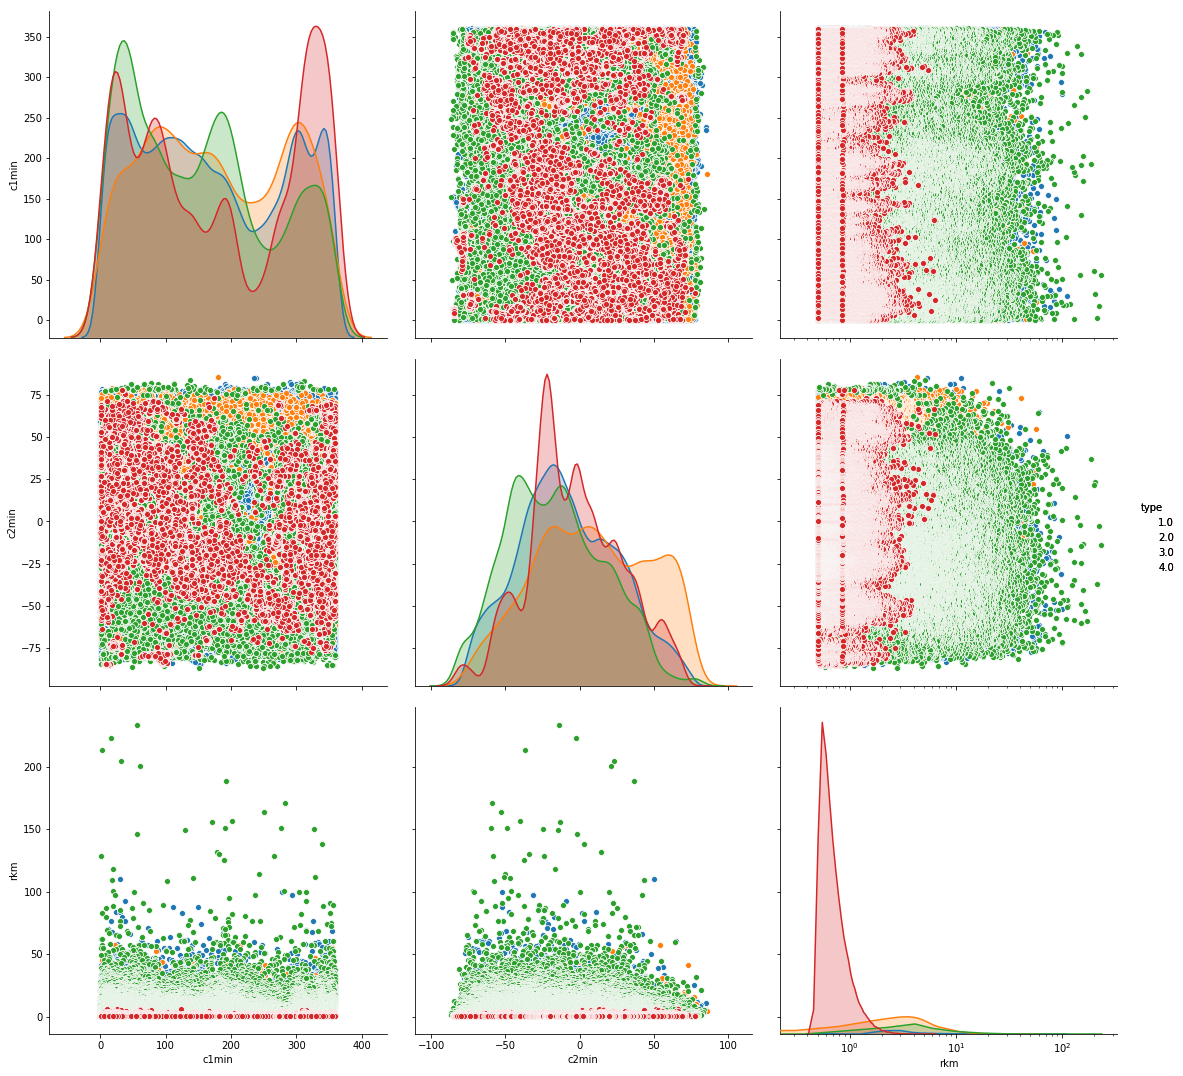

In [5]:
# Seaborn plots for data discovery
sns.color_palette('colorblind')
g = sns.pairplot(df,vars=["c1min","c2min","rkm"], height=5, hue="type")
g.axes[2,2].set(xscale="log")
#g.axes[2,0].set(yscale="log")
g.add_legend();

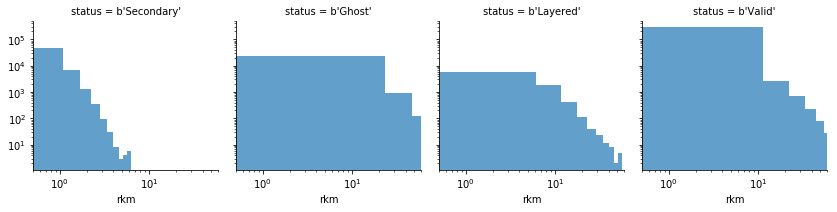

In [6]:
# Histograms on different types
g = sns.FacetGrid(df, col="status")
g.map(plt.hist, "rkm", alpha=.7).set(xlim=(0.5, 60), yscale='log', xscale='log');
#g.add_legend();

### 1D Density distribution
Using [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

See the Scikit-learn [kernel density estimation](https://scikit-learn.org/stable/modules/density.html)

In [9]:
from sklearn.neighbors import KernelDensity

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


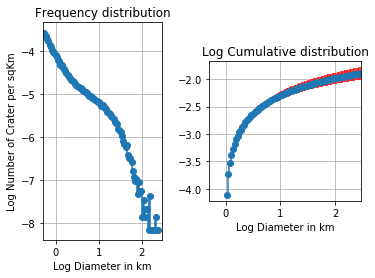

In [10]:
# Global surface for normalisation of the global catalog
surf_mars = 144798500. #(square kilometers)

# Plot together all crater types
plt.figure(1)

a1 = plt.subplot(121)

plt.xlabel('Log Diameter in km')
plt.ylabel('Log Number of Crater per sqKm')
plt.title('Frequency distribution')
plt.grid(True)

a2 = plt.subplot(122)
plt.xlabel('Log Diameter in km')
plt.title('Log Cumulative distribution')
plt.grid(True)

R = df.rkm[:,np.newaxis]
Rlog = np.log10(R)

maxlim = np.log10(300)
minlim = np.log10(min(R))

nstep = 100
#nstep = 10

bins = np.linspace(minlim, maxlim, nstep)

# histogram
ypos, bin_edges = np.histogram(Rlog[:, 0], bins=bins)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ypos = ypos / surf_mars
cum = np.cumsum(ypos)*(bin_edges[1:] + bin_edges[:-1])
a1.set_xlim(minlim, maxlim)
a1.errorbar( bin_centers, np.log10(ypos), yerr = ypos**0.5, marker = 'o', drawstyle = 'steps-mid', ecolor='r')
a2.set_xlim(minlim, maxlim)
a2.errorbar( bin_centers, np.log10(cum), yerr = cum**0.5, marker = 'o', drawstyle = 'steps-mid',ecolor='r')
a1.set_aspect('equal')
a2.set_aspect('equal')

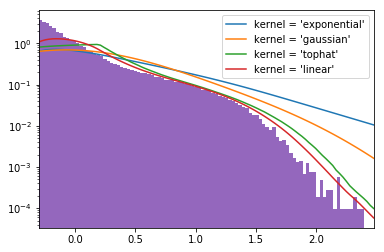

In [11]:
# Kernel density distribution for different kernels
lR_plot = np.linspace(minlim, maxlim, nstep-1)[:, np.newaxis]
fig, ax = plt.subplots()
plt.yscale('log')
for kernel in ['exponential','gaussian', 'tophat', 'linear']:
    kde = KernelDensity(kernel=kernel, bandwidth=.5).fit(Rlog)
    log_dens = kde.score_samples(lR_plot)
    ax.plot(lR_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.legend(loc='upper right')
plt.hist(Rlog, bins=bins,density='True')
ax.set_xlim(minlim, maxlim)

plt.show()

### 2D density distribution
See [Available metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) in scikit-learn

In [10]:
from sklearn.neighbors import DistanceMetric
deg2rad = np.pi/180.
rad2deg = 180./np.pi

In [11]:
# Using the metric on the sphere
dist = DistanceMetric.get_metric('haversine')
lon = np.linspace(0, 2*np.pi, 512)
lat = np.linspace(-np.pi/2., np.pi/2., 128)
lonv, latv = np.meshgrid(lon, lat)
lonlat = np.vstack([latv.ravel(), lonv.ravel()]).T
#print(lonlat)

In [15]:
rselect = df.loc[df['rkm']>5.]
#print(len(rselect))
# Lat Long as numpy arrays in radians
radlon = deg2rad*rselect.c1min.ravel()
radlat = deg2rad*rselect.c2min.ravel()

# Build the vector of lon lat pairs of crater coordinates
ll1=np.matrix(radlon).T
ll2=np.matrix(radlat).T
ll=np.hstack((ll2,ll1))
print(len(rselect))

23261


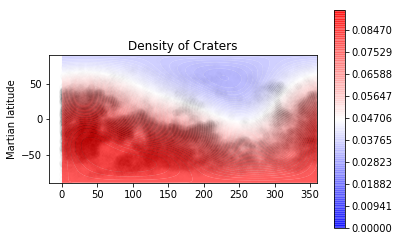

In [16]:
# bandwith definition
bw = 0.8
# construct a kernel density estimate of the distribution
kde = nb.KernelDensity(bandwidth=bw, metric='haversine',
                        kernel='gaussian',algorithm='ball_tree')
kde.fit(ll)

# evaluate over the whole surface
Z = np.exp(kde.score_samples(lonlat))
Z = Z.reshape(lonv.shape)

fig, ax = plt.subplots()
# plot contours of the density
#plt.imshow(img)

# Plot crater positions
plt.scatter(rselect.c1min.ravel(),rselect.c2min.ravel(), alpha=0.01, color='black')
levels = np.linspace(0, Z.max(), 100)
#levels = [17,34,59,93,136,187,250,330,1149]
plt.ylabel('Martian latitude')
plt.title('Density of Craters')
ax.set_aspect('equal')

# Plot density distribution
plt.contourf(lonv*rad2deg, latv*rad2deg, Z, levels=levels, cmap=plt.cm.get_cmap(name='bwr'),alpha=.7, antialiased=True)
plt.colorbar()

### Clustering
see [Clustering](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) in scikit-learn

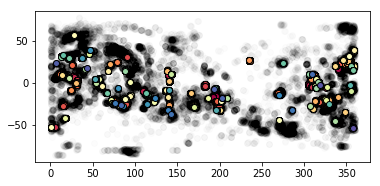

In [46]:
from sklearn.cluster import DBSCAN

secondary = df.loc[df['type']==b'4.0']
# Build the vector of lon lat pairs of crater coordinates
ll1=np.matrix(deg2rad*df.c1min.ravel()).T
ll2=np.matrix(deg2rad*df.c2min.ravel()).T
ll=np.hstack((ll2,ll1))
#print(len(ll))

db = DBSCAN(eps=0.01, min_samples=50, algorithm="ball_tree").fit(ll)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot result
fig, ax = plt.subplots()

# Plot secondary crater
plt.scatter(secondary.c1min.ravel(),secondary.c2min.ravel(), alpha=0.01, color='black')

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.1]

    class_member_mask = (labels == k)

    xy = ll[class_member_mask & core_samples_mask]
    plt.plot(rad2deg*xy[:, 1], rad2deg*xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    #xy = ll[class_member_mask & ~core_samples_mask]
    #plt.plot(rad2deg*xy[:, 0], rad2deg*xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

ax.set_aspect('equal')
plt.show()